In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, mannwhitneyu
import statsmodels.api as sm

from IPython.display import display

%matplotlib inline

plt.style.use('ggplot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data simulation

### Causal model:

* sugar intake &rarr; BMI
* smoking &rarr; lung cancer
* BMI, alcohol intake, lung cancer &rarr; death
* sex, age &rarr; everything else

<img src = "https://drive.google.com/uc?id=1eJhUFTLO5DaWvktB-yEP7tr47p6N8RHg" alt = "Causal diagram" width = 500px/>

In [2]:
N = 100000

def translate_to_range(values, new_min_value, new_max_value):
    values = (values - values.min()) / (values.max() - values.min())
    return new_min_value + (new_max_value - new_min_value) * values
    
def top_quantile_to_one(values, top_quantile):
    quantile_value = values.quantile(1 - top_quantile)
    return (values >= quantile_value).astype(int)
    
np.random.seed(100)

data = pd.DataFrame(index = np.arange(N))
data['sex'] = np.random.randint(0, 2, N) # 0 - female, 1 - male
data['age'] = np.random.randint(21, 100, N)
data['sugar_intake'] = translate_to_range(-data['age'] - 25 * data['sex'] + 300 * np.random.randn(N), 1, 5).round().astype(int)
data['alcohol_intake'] = translate_to_range(-data['age'] + 50 * data['sex'] + 100 * np.random.randn(N), 1, 5).round().astype(int)
data['smoking'] = top_quantile_to_one(data['age'] + 5 * data['sex'] + 200 * np.random.randn(N), 0.25)
data['BMI'] = translate_to_range(data['age'] - 3 * data['sex'] + 50 * data['sugar_intake'] + 200 * np.random.randn(N), 15, 45)\
        .round(1)
data['lung_cancer'] = top_quantile_to_one(data['age'] + 2 * data['sex'] + 200 * data['smoking'] + 200 * np.random.randn(N), \
        0.05)
data['death'] = top_quantile_to_one(data['age'] + 5 * data['sex'] + 0.5 * data['BMI'] + 1.5 * data['alcohol_intake'] + \
        30 * data['lung_cancer'] + 10 * np.random.randn(N), 0.2)
display(data)

,sex,age,sugar_intake,alcohol_intake,smoking,BMI,lung_cancer,death
0,0,23,3,3,0,27.8,0,0
1,0,79,3,3,0,30.4,0,0
2,1,82,3,3,0,32.3,0,0
3,1,97,2,3,0,33.4,0,1
4,1,67,2,4,0,37.0,0,0
...,...,...,...,...,...,...,...,...
99995,1,85,3,3,1,30.8,0,1
99996,0,78,3,3,0,27.6,0,1
99997,0,99,3,3,1,33.0,0,1
99998,0,33,3,3,0,35.7,0,0


# Multivariate linear regression

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


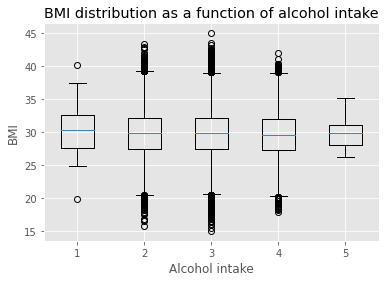

Spearman's rank correlation between alcohol intake to BMI: ρ = -0.02, p-value = 4.3e-08.


In [3]:
alcohol_intake_groups, BMI_values_in_groups = zip(*data.groupby('alcohol_intake')['BMI'])

fig, ax = plt.subplots()
ax.boxplot(BMI_values_in_groups)
ax.set_xlabel('Alcohol intake')
ax.set_xticklabels(alcohol_intake_groups)
ax.set_ylabel('BMI')
ax.set_title('BMI distribution as a function of alcohol intake')
plt.show()

print('Spearman\'s rank correlation between alcohol intake to BMI: ρ = %.2f, p-value = %.2g.' % \
        spearmanr(data['alcohol_intake'], data['BMI']))

There exists a weak (but very significant) association between alcohol intake to BMI. If not careful, one might jump to the conclusion that drinking alcohol affects weight. But according to the data modeling, we know there is no causal relationship between the two variables. This association is the result of confounders (sex and age).

In [4]:
y = data['BMI']
X = sm.add_constant(data[['sex', 'age', 'alcohol_intake']])
model = sm.OLS(y, X)
model_results = model.fit()
regression_pval = model_results.pvalues['alcohol_intake']
print('The effect of alcohol intake on BMI (after adjusting for sex and age as covariates): p-value = %.2g.' % regression_pval)

The effect of alcohol intake on BMI (after adjusting for sex and age as covariates): p-value = 0.28.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [5]:
model_results.pvalues

const              0.000000e+00
sex                4.718942e-06
age               3.823627e-260
alcohol_intake     2.757631e-01
dtype: float64

In [6]:
print(model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     413.3
Date:                Tue, 08 Mar 2022   Prob (F-statistic):          7.79e-267
Time:                        00:50:38   Log-Likelihood:            -2.6452e+05
No. Observations:              100000   AIC:                         5.291e+05
Df Residuals:                   99996   BIC:                         5.291e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             28.7479      0.074    387.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


The effect of sugar intake on BMI (after adjusting for sex and age as covariates): p-value = 0.


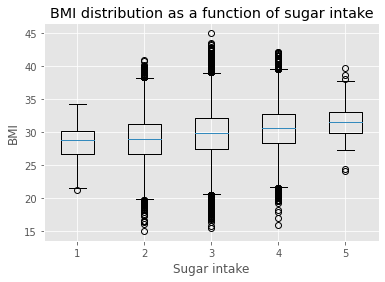

In [7]:
model_results = sm.OLS(data['BMI'], sm.add_constant(data[['sex', 'age', 'sugar_intake']])).fit()
regression_pval = model_results.pvalues['sugar_intake']
print('The effect of sugar intake on BMI (after adjusting for sex and age as covariates): p-value = %.2g.' % regression_pval)

sugar_intake_groups, BMI_values_in_groups = zip(*data.groupby('sugar_intake')['BMI'])
fig, ax = plt.subplots()
ax.boxplot(BMI_values_in_groups)
ax.set_xlabel('Sugar intake')
ax.set_xticklabels(sugar_intake_groups)
ax.set_ylabel('BMI')
ax.set_title('BMI distribution as a function of sugar intake')
plt.show()

Sugar intake is very significantly associated with BMI, even after controlling for sex and age. This is not surprising, as we modeled sugar intake to have a very strong causal effect on BMI.

In [8]:
'''
We can also include smoking and alcohol intake as additional covariates in this case, although it's not really necessary
(according to our causal model, sex and age are the only confounders we need to account for).
Of course not always we can be certain which variables are the relevant confounders. In many cases it is safe to include more
covaraites, but in some cases it can be dangerous (we will see an example later).
'''
sm.OLS(data['BMI'], sm.add_constant(data[['sex', 'age', 'alcohol_intake', 'smoking', 'sugar_intake']])).fit()\
        .pvalues['sugar_intake']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.0

# Logistic regression

In [9]:
n_samples_per_alcohol_intake_and_lung_cancer_group = data.groupby('lung_cancer')['alcohol_intake'].value_counts().sort_index()\
        .unstack().fillna(0)
alcohol_intake_dist_given_lung_cancer = 100 * n_samples_per_alcohol_intake_and_lung_cancer_group.divide(\
        n_samples_per_alcohol_intake_and_lung_cancer_group.sum(axis = 1), axis = 0)
display(alcohol_intake_dist_given_lung_cancer.applymap(lambda pctg: '%.2f%%' % pctg))

alcohol_intake_given_lung_cancer = data.loc[data['lung_cancer'] == 1, 'alcohol_intake']
alcohol_intake_given_no_lung_cancer = data.loc[data['lung_cancer'] == 0, 'alcohol_intake']
_, utest_pval = mannwhitneyu(alcohol_intake_given_lung_cancer, alcohol_intake_given_no_lung_cancer)
print('U-test p-value = %.2g' % utest_pval)

alcohol_intake,1,2,3,4,5
lung_cancer,,,,,
0,0.05%,16.84%,73.63%,9.45%,0.03%
1,0.02%,18.78%,72.54%,8.66%,0.00%


U-test p-value = 0.0001


Alcohol intake is associated with lung cancer, even though we know it is a spurious correlation.

In [10]:
y = data['lung_cancer']
X = sm.add_constant(data[['sex', 'age', 'alcohol_intake']])
model = sm.Logit(y, X)
model_results = model.fit()
regression_pval = model_results.pvalues['alcohol_intake']
print(50 * '*')
print('The effect of alcohol intake on lung cancer (after adjusting for sex and age as covariates): p-value = %.2g.' % \
        regression_pval)

Optimization terminated successfully.
         Current function value: 0.196214
         Iterations 7
**************************************************
The effect of alcohol intake on lung cancer (after adjusting for sex and age as covariates): p-value = 0.83.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
model_results.pvalues

const             2.593721e-306
sex                1.580697e-01
age                1.347985e-95
alcohol_intake     8.300197e-01
dtype: float64

In [12]:
print(model_results.summary())

                           Logit Regression Results                           
Dep. Variable:            lung_cancer   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99996
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Mar 2022   Pseudo R-squ.:                 0.01159
Time:                        00:50:50   Log-Likelihood:                -19621.
converged:                       True   LL-Null:                       -19852.
Covariance Type:            nonrobust   LLR p-value:                 2.048e-99
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.8174      0.102    -37.411      0.000      -4.017      -3.617
sex                0.0419      0.030      1.412      0.158      -0.016       0.100
age                0.0138      0.001

In [13]:
model_results = sm.Logit(data['lung_cancer'], sm.add_constant(data[['sex', 'age', 'smoking']])).fit()
regression_pval = model_results.pvalues['smoking']
print(50 * '*')
print('The effect of smoking intake on lung cancer (after adjusting for sex and age as covariates): p-value = %.2g.' % \
        regression_pval)

Optimization terminated successfully.
         Current function value: 0.170995
         Iterations 8
**************************************************
The effect of smoking intake on lung cancer (after adjusting for sex and age as covariates): p-value = 0.


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
'''
Here too we may include more covariates than really necessary.
'''
sm.Logit(data['lung_cancer'], sm.add_constant(data[['sex', 'age', 'smoking', 'alcohol_intake', 'sugar_intake']])).fit()\
        .pvalues['smoking']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.170993
         Iterations 8


0.0

# Colliders

In [15]:
sm.OLS(data['BMI'], sm.add_constant(data[['sex', 'age', 'lung_cancer']])).fit().pvalues['lung_cancer']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


0.6011359076549263

BMI is not associated with lung cancer (conditional on sex and age), as expected.

<img src = "https://drive.google.com/uc?id=1eJhUFTLO5DaWvktB-yEP7tr47p6N8RHg" alt = "Causal diagram" width = 500px/>

But what happens if we also condition on death?

In [16]:
sm.OLS(data['BMI'], sm.add_constant(data[['sex', 'age', 'lung_cancer', 'death']])).fit().pvalues['lung_cancer']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


1.5033394639178423e-09

This is known as a collider. Since both BMI and and lung cancer affect death, __we must NOT control for it!__

Intuitively, if a dead person didn't have lung cancer, his death might be explained by his BMI; but if he did have lung cancer, that may already explain away his death. Therefore, we expect to find a negative correlation between BMI and lung cancer when coditioning on death (as opposed to no correlation at all when we don't condition on a collider).

A commonly used toy example: __Hollywood actors__

<img src = "https://drive.google.com/uc?id=1XelfNNoR6ZIO-7tzXGVGWhqERFRelWXl" alt = "Causal diagram" width = 300px/>

__"Controlling for everything" is deeply misguided!__ (Recommended reading: "The Book of Why" by Judea Pearl)